In [1]:
# @title Dowloand the demo data
# Let's start with loading the image for segmentation

!wget https://polybox.ethz.ch/index.php/s/ddFUpadTSRgDycr/download -O image_examples.zip
!unzip image_examples.zip
%cd /content/for_segmentation/
!wget https://upload.wikimedia.org/wikipedia/commons/d/dc/Kazimir_Malevich%2C_1915%2C_Black_Suprematic_Square%2C_oil_on_linen_canvas%2C_79.5_x_79.5_cm%2C_Tretyakov_Gallery%2C_Moscow.jpg -O black_square.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/White_on_White_%28Malevich%2C_1918%29.png/1280px-White_on_White_%28Malevich%2C_1918%29.png -O white_on_white.jpg
%cd /content

--2024-10-22 07:28:33--  https://polybox.ethz.ch/index.php/s/ddFUpadTSRgDycr/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3054155 (2.9M) [application/zip]
Saving to: ‘image_examples.zip’

image_examples.zip  100%[===================>]   2.91M  2.46MB/s    in 1.2s    

2024-10-22 07:28:35 (2.46 MB/s) - ‘image_examples.zip’ saved [3054155/3054155]

Archive:  image_examples.zip
   creating: for_segmentation/
  inflating: for_segmentation/tool.jpg  
  inflating: for_segmentation/.DS_Store  
  inflating: for_segmentation/coffee_tools.jpg  
  inflating: for_segmentation/notebook.jpg  
  inflating: for_segmentation/hemostata_pencil.jpg  
  inflating: for_segmentation/books_tools.jpg  
  inflating: for_segmentation/qr_code.jpg  
  inflating: for_segmentation/hemostat.jpg  
/content/for_segmentation
--2024-10-22 07:28:35--  https://up

In [2]:
# @title Basic imports, auxiliary functions for image loading
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_img(img_path):
  img = Image.open(img_path)
  img = np.asarray(img) / 255
  return img

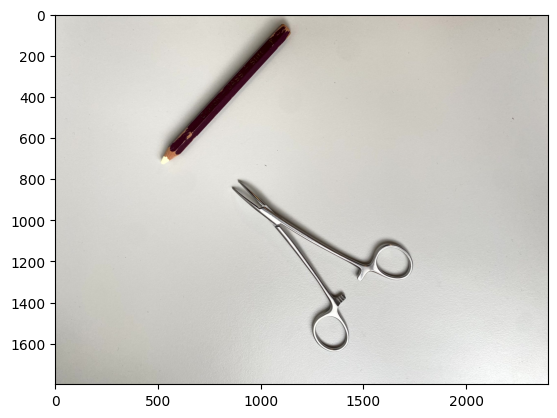

In [3]:
# load image as PyTorch tensor
img = load_img('/content/for_segmentation/hemostata_pencil.jpg')
# get image dimensions
img_height, img_width, n_channels = img.shape
plt.imshow(img)

In [4]:
# @title Auxiliary function for converting labels to colors

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def labels_to_colors(labels, K):
    """
    Converts an integer label to its corresponding color.
    """

    # Get a color palette from a colormap (tab20) and convert it to RGB
    color_palette = plt.cm.get_cmap('rainbow', K)(range(K))[:, :3]

    colors = color_palette[labels]

    return colors, color_palette

In [5]:
from sklearn.mixture import GaussianMixture

# convert pixels to data points and run GMM
X = img.reshape([-1, n_channels])
k = 2
gmm = GaussianMixture(n_components=k).fit(X)

In [6]:
# predict labels
labels = gmm.predict(X)
colors, palette = labels_to_colors(labels, K=k)
image_segments = colors.reshape([img_height, img_width, 3])

# compute densities of each clusters for each data point
probs = gmm.predict_proba(X).reshape([img_height, img_width, k])

# compute log-likelihoods of each data point
scores = gmm.score_samples(X).reshape([img_height, img_width])

<ipython-input-4-6da24f72de80>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('rainbow', K)(range(K))[:, :3]


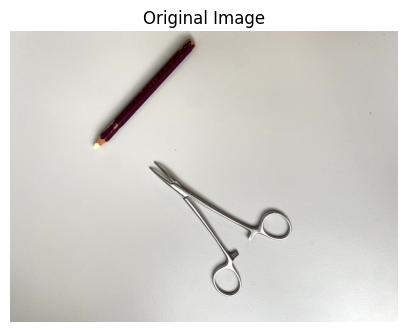

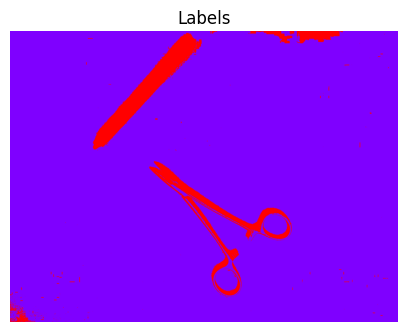

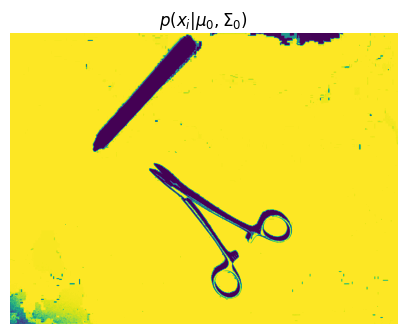

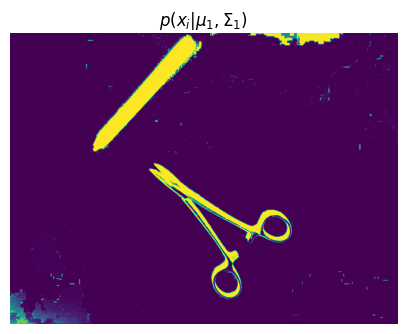

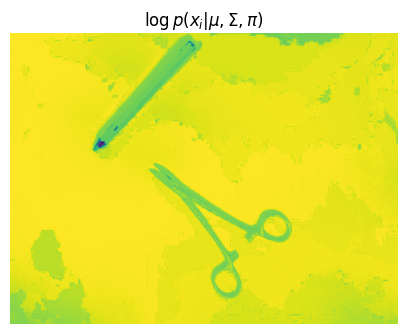

In [7]:
# plot original image
plt.figure(figsize=(5, 5))
plt.title("Original Image")
plt.axis('off')
plt.imshow(img, interpolation=None)
plt.savefig("original.jpg", dpi=300)

# plot labels
plt.figure(figsize=(5, 5))
plt.title("Labels")
plt.axis('off')
plt.imshow(image_segments, interpolation=None)
plt.savefig("labels.jpg", dpi=300)

# plot densities
for i in range(k):
  plt.figure(figsize=(5, 5))
  plt.axis('off')
  plt.title("$p(x_i | \mu_%d, \Sigma_%d)$"%(i, i))
  plt.imshow(probs[:, :, i], interpolation=None)
  plt.savefig("density_%d.jpg"%i, dpi=300)

# log-likelihoods
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title("$ \log p(x_i | \mu, \Sigma, \pi)$")
plt.imshow(scores, interpolation=None)
plt.savefig("likelihood.jpg", dpi=300)